# Бонусная лабораторная работа 9. Часть 1. Ранжирование.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 9 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Ранжирование организаций по пользовательскому запросу

Что мы обычно делаем, когда нам нужно найти определённое место, но не знаем его местоположения? Используем поиск на картах.

В этой лабораторной работе вам будет необходимо построить небольшую поисковую систему, позволяющую отранжировать организации по запросу пользователя.

Для обучения вам даны 2000 запросов и более 13 тысяч найденных по ним организаций. Для каждой пары "запрос — организация" была посчитана релевантность, по которой и происходит ранжирование.

**(2 балла) Задание 1.** Загрузите [данные](https://disk.yandex.ru/d/Bf3P4H8FDYe7-g) о запросах и их релевантности (*train.csv*), а также информацию об организациях (*train_org_information.json*) и рубриках (*train_rubric_information.json*)

Для дальнейших экспериментов необходимо посчитать небольшой набор базовых факторов. С использованием информации о запросах и организациях, посчитайте факторы, которые на ваш взгляд будут полезными для предсказания релевантности.

Примерами текстовых факторов могут служить:
 - кол-во слов в запросе и названии организации;
 - пословные/N-граммные пересечения слов запроса и названия организации (также можно использовать синонимы названия организации и адрес организации): кол-во слов в пересечении, [мера Жаккара](https://en.wikipedia.org/wiki/Jaccard_index) и пр.;
 - кол-во различных синонимичных названий организации (поле *names* в описании организации);
 - One-hot-encoded язык запроса.
 
По информации о географическом положении:
 - факт совпадения региона, где задавался запрос и региона организации;
 - координаты показанной области;
 - размеры показанной области;
 - меры, характеризующие близость координат организации к показанному окну: расстояние до центра области и другие.
 
Факторы, описывающие организацию:
 - one-hot-encoding фактор cтраны или региона организации (важно: не используйте one-hot-encoding факторы, в которых больше 10 значений; если в факторе слишком много значений, ограничьтесь, например, только самыми популярными категориями)
 - кол-во рабочих дней в неделе и общая продолжительность работы (поле *work_intervals* в описании организации)
 - кол-во рубрик (поле *rubrics* в описании организации)
 
![](https://miro.medium.com/max/1500/0*FwubnnoNlt6Coo9j.png)

В этом задании не нужно использовать многомерные представления текстовой информации (tfidf и прочие embeddings) и информацию о кликах (*train_clicks_information.json*). Придумывать сверхсложные факторы тоже необязательно.

Вы можете реализовать описанные выше факторы и/или придумать свои. Но зачастую такие простые признаки могут приносить наибольшую пользу.

В итоге у вас должно получиться от 15 до 50 факторов, характеризующих запрос и организацию и покрывающих основные источники данных (кроме кликов). Это наш основной датасет, который будет использоваться в экспериментах.



---
### Preprocessing

In [1]:
%load_ext nb_black

import json
import pickle
import os
import requests
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap
from sklearn.feature_extraction.text import CountVectorizer
from urllib.parse import urlencode


def parse_series_of_lists_of_dicts(
    series, record_names=("locale", "value"), category_column="locale"
):
    index_name = series.index.name or "index"
    series_name = series.name or 0
    df = (
        pd.json_normalize(
            series.to_frame().reset_index().to_dict(orient="records"),
            record_path=[series_name],
            meta=[index_name],
        )
        .rename(columns={f"value.{i}": i for i in record_names})
        .astype({index_name: int, category_column: "category"})
        .set_index(index_name)
    )

    return df


def preprocess_train_csv(data_dir):
    train = pd.read_csv(os.path.join(data_dir, "train.csv"))
    train = pd.concat(
        [
            train.drop(["window_center", "window_size"], axis="columns"),
            train["window_center"]
            .str.split(",", expand=True)
            .astype(float)
            .rename(
                columns={
                    0: f"window_center_longitude",
                    1: f"window_center_latitude",
                }
            ),
            train["window_size"]
            .str.split(",", expand=True)
            .astype(float)
            .rename(
                columns={
                    0: f"window_size_longitude",
                    1: f"window_size_latitude",
                }
            ),
        ],
        axis="columns",
    ).rename(columns={"region": "geo_id"})

    return train


def preprocess_train_org_information_csv(data_dir):
    orgs = pd.read_json(
        os.path.join(data_dir, "train_org_information/train_org_information.json"),
        orient="index",
        convert_axes=False,
    )
    orgs.index = orgs.index.astype(int).rename("org_id")

    org_names = parse_series_of_lists_of_dicts(orgs["names"])

    rubrics = orgs["rubrics"].explode().astype(int).to_frame()

    work_intervals = parse_series_of_lists_of_dicts(
        orgs["work_intervals"],
        category_column="day",
    )
    work_intervals = pd.concat(
        [
            (g := work_intervals.groupby(["org_id", "day"]))[
                "time_minutes_begin"
            ].min(),
            g["time_minutes_end"].max(),
        ],
        axis="columns",
    )
    work_intervals["work_intervals"] = (
        work_intervals[["time_minutes_begin", "time_minutes_end"]]
        .loc[work_intervals["time_minutes_begin"].notna()]
        .agg(tuple, axis="columns")
    )
    work_intervals = work_intervals.reset_index().pivot(
        index="org_id", columns="day", values="work_intervals"
    )
    work_intervals = (
        work_intervals.fillna(
            {column: work_intervals["everyday"] for column in work_intervals.columns}
        )
        .fillna(
            {
                column: work_intervals["weekdays"]
                for column in ["monday", "tuesday", "wednesday", "thursday", "friday"]
            }
        )
        .fillna(
            {column: work_intervals["weekend"] for column in ["saturday", "sunday"]}
        )
        .drop(["everyday", "weekdays", "weekend"], axis="columns")
    )

    org_address = (
        pd.json_normalize(orgs["address"])
        .set_index(orgs.index)
        .rename(
            columns={"formatted.locale": "address_locale", "formatted.value": "address"}
        )
        .astype(
            {
                "region_code": "category",
                "geo_id": "int64",
                "address_locale": "category",
            }
        )
        .drop(["pos.type", "postal_code"], axis=1)
    )
    org_address["region_code"] = (
        org_address["region_code"].str.lower().astype("category")
    )

    orgs = pd.concat(
        [
            orgs.drop(
                ["names", "rubrics", "work_intervals", "address"], axis="columns"
            ),
            org_address.drop("pos.coordinates", axis="columns"),
            pd.DataFrame(
                org_address["pos.coordinates"].to_list(),
                columns=["longitude", "latitude"],
                index=orgs.index,
            ),
            work_intervals,
        ],
        axis="columns",
    )

    return orgs, org_names, rubrics


def preprocess_train_rubric_information_json(data_dir):
    train_rubric_information = pd.read_json(
        os.path.join(
            data_dir, "train_rubric_information/train_rubric_information.json"
        ),
        orient="index",
    ).rename_axis("rubric_id")

    rubric_names = parse_series_of_lists_of_dicts(train_rubric_information["names"])
    rubric_keywords = parse_series_of_lists_of_dicts(
        train_rubric_information["keywords"]
    )
    rubric_phrases = parse_series_of_lists_of_dicts(train_rubric_information["phrases"])
    rubric_descriptions = parse_series_of_lists_of_dicts(
        train_rubric_information["descriptions"]
    )
    return rubric_names, rubric_keywords, rubric_phrases, rubric_descriptions

<IPython.core.display.Javascript object>

In [2]:
DATA_DIR = "data/hw_ranking_data"

train = preprocess_train_csv(DATA_DIR)

orgs, org_names, rubrics = preprocess_train_org_information_csv(DATA_DIR)
(
    rubric_names,
    rubric_keywords,
    rubric_phrases,
    rubric_descriptions,
) = preprocess_train_rubric_information_json(DATA_DIR)

<IPython.core.display.Javascript object>

### Feature generation

In [3]:
def top_k_dummies(series, top_k=5, **kwargs):
    series = series.astype("category").cat.remove_categories(
        series.value_counts().index[top_k:]
    )
    return pd.get_dummies(series, **kwargs)


def process_queries(train, org_names):
    queries = (
        train.drop(["org_id", "relevance"], axis="columns")
        .set_index("query_id")
        .groupby("query_id")
        .first()
    )
    queries.index = queries.index.astype(int)

    queries["n_words"] = queries["query"].str.split().apply(len)
    queries["window_size"] = (
        queries["window_size_longitude"] * queries["window_size_latitude"]
    )

    names_to_locale = org_names.groupby("value")["locale"].agg(lambda s: s.mode()[0])
    known_locales = queries["org_name"].isin(names_to_locale.index)
    queries["locale"] = "ru"
    queries.loc[known_locales, "locale"] = names_to_locale[
        queries["org_name"][known_locales]
    ].values
    queries["locale"] = queries["locale"].astype("category")
    queries = pd.concat(
        [
            queries.drop(["org_name"], axis="columns"),
            top_k_dummies(queries["locale"], top_k=4, prefix="locale"),
            top_k_dummies(queries["geo_id"], prefix="geo_id"),
        ],
        axis=1,
    )

    return queries

<IPython.core.display.Javascript object>

In [4]:
def process_work_intervals(orgs):
    orgs["average_work_interval"] = (
        orgs[
            [
                "monday",
                "tuesday",
                "wednesday",
                "thursday",
                "friday",
                "saturday",
                "sunday",
            ]
        ]
        .apply(lambda series: pd.arrays.IntervalArray.from_tuples(series).length)
        .mean(axis="columns")
    )
    orgs["average_work_interval"] = orgs["average_work_interval"].fillna(
        orgs["average_work_interval"].mean()
    )
    orgs["workdays_count"] = (
        orgs[
            [
                "monday",
                "tuesday",
                "wednesday",
                "thursday",
                "friday",
                "saturday",
                "sunday",
            ]
        ]
        .notna()
        .sum(axis="columns")
    ).replace(0, pd.NA)
    orgs["workdays_count"] = orgs["workdays_count"].fillna(
        orgs["workdays_count"].mean()
    )
    grouped_work_intervals = (
        pd.concat(
            [
                pd.DataFrame(
                    orgs[day].to_list(),
                    index=orgs.index,
                    columns=["weekend_from", "weekend_to"]
                    if day in ["saturday", "sunday"]
                    else ["weekdays_from", "weekdays_to"],
                )
                for day in [
                    "monday",
                    "tuesday",
                    "wednesday",
                    "thursday",
                    "friday",
                    "saturday",
                    "sunday",
                ]
            ],
            axis="columns",
        )
        .T.reset_index()
        .groupby("index")
        .mean()
        .T
    )
    orgs = orgs.drop(
        [
            "monday",
            "tuesday",
            "wednesday",
            "thursday",
            "friday",
            "saturday",
            "sunday",
        ],
        axis="columns",
    ).join(grouped_work_intervals)
    orgs.index = orgs.index.astype(int)
    return orgs


def process_rubrics(orgs):
    def filter_locales(dataframe, locales):
        if "locale" not in dataframe:
            return dataframe
        return dataframe[dataframe["locale"].isin(locales)]

    def group_locales(dataframe, prefix=""):
        dataframe = (
            dataframe.reset_index()
            .groupby([dataframe.index.name, "locale"], observed=True)["value"]
            .apply(" ".join)
            .reset_index()
            .pivot(index=dataframe.index.name, columns="locale", values="value")
        )
        return dataframe.rename(columns={c: prefix + c for c in dataframe})

    locales = [c.split("_")[1] for c in queries.columns if c.startswith("locale_")]

    org_names_grouped = group_locales(
        filter_locales(org_names, locales), prefix="org_names_"
    )

    rubric_dataframes = [
        rubrics.reset_index().set_index("rubrics"),
        rubric_names,
        rubric_phrases,
        rubric_keywords,
        rubric_descriptions,
    ]
    rubric_dataframes = [filter_locales(df, locales) for df in rubric_dataframes]
    valid_rubric_ids = pd.Index(
        set.intersection(*[set(df.index) for df in rubric_dataframes])
    )
    rubric_dataframes = [
        df.loc[valid_rubric_ids.intersection(df.index)].rename_axis("rubrics")
        for df in rubric_dataframes
    ]
    rubric_dataframe = pd.concat(
        [group_locales(df) for df in rubric_dataframes[1:]], axis=1
    )
    rubric_dataframe = pd.concat(
        [
            rubric_dataframe[column]
            .astype(str)
            .agg(" ".join, axis=1)
            .rename("rubric_" + column)
            for column in rubric_dataframe.columns.unique()
        ],
        axis=1,
    )
    rubric_dataframe = (
        rubric_dataframes[0]
        .reset_index()
        .groupby("org_id")["rubrics"]
        .apply(lambda s: rubric_dataframe.loc[s].apply(" ".join))
        .reset_index()
        .pivot(index="org_id", columns="level_1", values="rubrics")
    )

    return orgs.join([org_names_grouped, rubric_dataframe])


def process_orgs(orgs):
    orgs = process_work_intervals(orgs)
    orgs = process_rubrics(orgs)

    orgs["names_count"] = org_names.groupby("org_id").size()
    orgs["rubrics_count"] = rubrics.groupby("org_id").count()
    orgs["n_words"] = (
        org_names.reset_index()
        .groupby("org_id")["value"]
        .apply(lambda s: s.str.split().apply(len).mean())
    )

    orgs = pd.concat(
        [
            train.drop_duplicates("org_id").set_index("org_id")["org_name"],
            orgs,
            top_k_dummies(orgs["address_locale"], prefix="locale"),
            top_k_dummies(orgs["region_code"], prefix="region"),
            top_k_dummies(orgs["geo_id"], top_k=10, prefix="geo_id"),
        ],
        axis="columns",
    )
    return orgs

<IPython.core.display.Javascript object>

In [5]:
def normalize_text(series, **kwargs):
    analyzer = CountVectorizer(**kwargs).build_analyzer()
    return series.apply(analyzer).str.join(" ")


def count_equal_words(left: "pd.Series", right: "pd.Series", **vectorizer_kwargs):
    analyzer = CountVectorizer(**vectorizer_kwargs).build_analyzer()
    left = left.apply(analyzer).apply(set)
    right = right.apply(analyzer).apply(set)
    series = pd.Series(
        left.values & right.values,
        index=left.index,
    ).apply(len)
    return series


def jaccard_index(left: "pd.Series", right: "pd.Series", **vectorizer_kwargs):
    analyzer = CountVectorizer(**vectorizer_kwargs).build_analyzer()
    left = left.apply(analyzer).apply(set)
    right = right.apply(analyzer).apply(set)
    series = pd.Series(
        np.fromiter(map(len, (left.values & right.values)), dtype=int)
        / (
            np.fromiter(map(len, (left.values | right.values)), dtype=int)
            + np.finfo(float).eps
        ),
        index=left.index,
    )
    return series


def process_text_data(train):
    train["n_words_difference"] = abs(train["queries_n_words"] - train["orgs_n_words"])

    orgs_text = pd.DataFrame(index=train.index)
    orgs_text["name"] = train["orgs_org_name"]
    orgs_text["address"] = train["orgs_address"]
    orgs_text["all_names"] = ""
    orgs_text["rubric"] = ""

    languages = ["ru", "uk", "en", "tr"]

    train["same_name_language"] = (
        train[[f"orgs_locale_{l}" for l in languages]]
        * train[[f"queries_locale_{l}" for l in languages]].values
    ).sum(axis="columns")

    orgs_address_dummies = top_k_dummies(train["orgs_address_locale"], top_k=4)
    train["same_address_language"] = (
        orgs_address_dummies[[f"{l}" for l in languages]]
        * train[[f"queries_locale_{l}" for l in languages]].values
    ).sum(axis="columns")

    for language in languages:
        mask = train[f"queries_locale_{language}"].astype(bool)
        orgs_text.loc[mask, "all_names"] = train.loc[mask, f"orgs_org_names_{language}"]
        orgs_text.loc[mask, "rubric"] = train.loc[mask, f"orgs_rubric_{language}"]

    for column, series in orgs_text.iteritems():
        train[f"equal_words_count_{column}"] = count_equal_words(
            train["queries_query"], series
        )
        train[f"equal_quadgrams_count_{column}"] = count_equal_words(
            train["queries_query"], series, analyzer="char", ngram_range=(4, 4)
        )
        train[f"jaccard_index_{column}"] = jaccard_index(
            train["queries_query"], series, analyzer="char", ngram_range=(4, 4)
        )

    return train


def process_geo_data(train):
    train["same_geo_id"] = (train["queries_geo_id"] == train["orgs_geo_id"]).astype(int)

    train["distance_from_center"] = (
        (train["queries_window_center_longitude"] - train["orgs_longitude"]) ** 2
        + (train["queries_window_center_latitude"] - train["orgs_latitude"]) ** 2
    ) ** 0.5

    train["inside_window"] = (
        (
            abs(train["queries_window_center_longitude"] - train["orgs_longitude"])
            < train["queries_window_size_longitude"]
        )
        & (
            abs(train["queries_window_center_latitude"] - train["orgs_latitude"])
            < train["queries_window_size_latitude"]
        )
    ).astype(int)

    return train


def process_train(train, queries, orgs):
    for text_column_name, series in queries.select_dtypes(object).iteritems():
        queries[text_column_name] = normalize_text(series.fillna(""))

    for text_column_name, series in orgs.select_dtypes(object).iteritems():
        orgs[text_column_name] = normalize_text(series.fillna(""))

    train = train[["query_id", "org_id", "relevance"]]
    train = (
        train[["query_id", "org_id", "relevance"]]
        .join(queries.add_prefix("queries_"), on="query_id")
        .join(orgs.add_prefix("orgs_"), on="org_id")
    )

    train = process_text_data(train)
    train = process_geo_data(train)

    return train

<IPython.core.display.Javascript object>

In [6]:
def get_yandex_disk_download_url(yandex_disk_url):
    base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"
    url = base_url + urlencode(dict(public_key=yandex_disk_url))
    response = requests.get(url)
    if "href" not in response.json():
        raise RuntimeError(f"Yandex api returned error:\n{response.json()}")

    download_url = response.json()["href"]
    return download_url


def get_query_coordinates(yandex_disk_url="https://disk.yandex.ru/d/GlByrcCf4cHVOQ"):
    download_url = get_yandex_disk_download_url(yandex_disk_url)

    regions = pd.read_csv(
        download_url,
        delimiter=";",
        header=None,
        names=["geo_id", "name", "address", "coordinates"],
    )
    regions = (
        regions.drop(["coordinates"], axis="columns")
        .join(
            pd.DataFrame(
                regions["coordinates"].str.split(",").to_list(),
                columns=["longitude", "latitude"],
            )
        )
        .set_index("geo_id")
    )

    query_coordinates = regions.loc[
        queries.query("geo_id in @regions.index")["geo_id"], ["longitude", "latitude"]
    ].astype(float)

    return query_coordinates

<IPython.core.display.Javascript object>

In [7]:
def plot_geo_data(
    orgs,
    queries,
    query_coordinates,
    quantile=0.95,
    figsize=(16, 16),
    border_lon=15,
    border_lat=20,
):
    fig = plt.figure(figsize=figsize)

    llcrnrlon, urcrnrlon = pd.concat(
        [orgs["longitude"], queries["window_center_longitude"]]
    ).quantile([1 - quantile, quantile])
    llcrnrlat, urcrnrlat = pd.concat(
        [orgs["latitude"], queries["window_center_latitude"]]
    ).quantile([1 - quantile, quantile])

    basemap = Basemap(
        llcrnrlon=llcrnrlon - border_lon,
        llcrnrlat=llcrnrlat - border_lat,
        urcrnrlon=urcrnrlon + border_lon,
        urcrnrlat=urcrnrlat + border_lat,
    )

    basemap.drawcountries()
    basemap.fillcontinents(lake_color="0.9")

    basemap.scatter(
        query_coordinates["longitude"],
        query_coordinates["latitude"],
        alpha=0.05,
        marker="h",
        color="C1",
        s=1000,
    )
    basemap.scatter(
        queries["window_center_longitude"],
        queries["window_center_latitude"],
        alpha=0.3,
        color="C2",
        marker="s",
    )
    basemap.scatter(
        orgs["longitude"], orgs["latitude"], alpha=0.75, color="C0", marker=".", s=10
    )

    query_from_marker = basemap.scatter([], [], marker="h", c="C1")
    query_window_marker = basemap.scatter([], [], marker="s", c="C2")
    orgs_marker = basemap.scatter([], [], marker=".", c="C0")

    plt.legend(
        handles=[query_from_marker, query_window_marker, orgs_marker],
        labels=["regions the queries were made from", "shown windows", "orgs"],
    )

    plt.show()

<IPython.core.display.Javascript object>

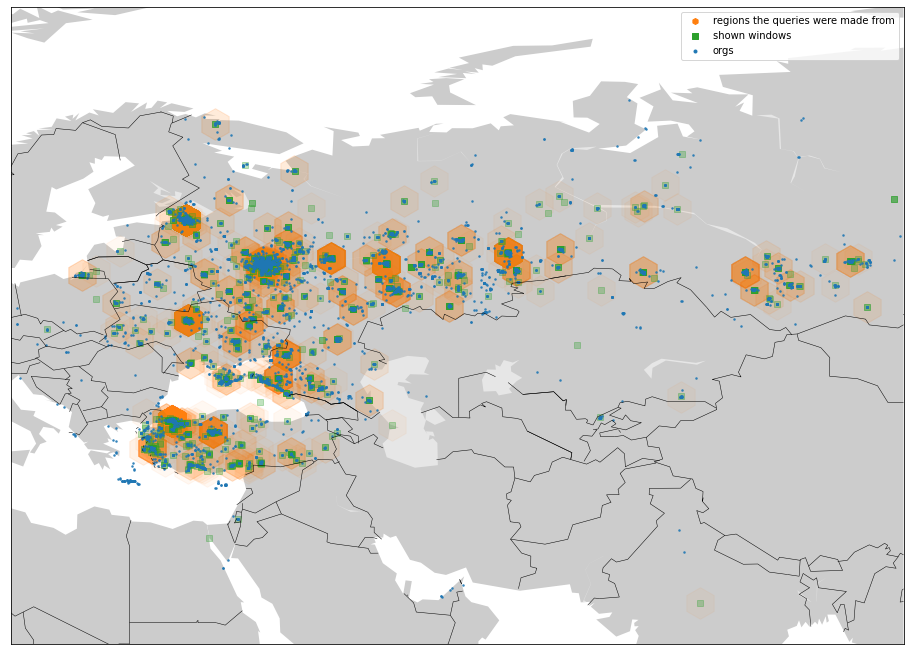

<IPython.core.display.Javascript object>

In [8]:
rewrite_train = False
train_pickle_file = "ranking_lab_train.pickle"

queries = process_queries(train, org_names)
orgs = process_orgs(orgs)

if not os.path.isfile(train_pickle_file) or rewrite_train:
    train = process_train(train, queries, orgs)
    pickle.dump(train, open(train_pickle_file, "wb"))
else:
    train = pickle.load(open(train_pickle_file, "rb"))

plot_geo_data(orgs, queries, query_coordinates=get_query_coordinates())

## Ранжирование

![](http://i.imgur.com/2QnD2nF.jpg)

Задачу поискового ранжирования можно описать следующим образом: имеется множество документов $d \in D$ и множество запросов $q \in Q$. Требуется оценить *степень релевантности* документа по отношению к запросу: $(q, d) \mapsto r$, относительно которой будет производиться ранжирование. Для восстановления этой зависимости используются методы машинного обучения. Обычно используется три типа:
 - признаки запроса $q$, например: мешок слов текста запроса, его длина, ...
 - документа $d$, например: значение PageRank, мешок слов, доменное имя, ...
 - пары $(q, d)$, например: число вхождений фразы из запроса $q$ в документе $d$, ...

Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.
### Подходы к решению задачи ранжирования
Существуют 3 основных подхода, различие между которыми в используемой функции потерь:
  
1. **Pointwise подход**. В этом случае рассматривается *один объект* (в случае поискового ранжирования - конкретный документ) и функция потерь считается только по нему. Любой стандартный классификатор или регрессор может решать pointwise задачу ранжирования, обучившись предсказывать значение таргета. Итоговое ранжирование получается после сортировки документов к одному запросу по предсказанию такой модели.
2. **Pairwise подход**. В рамках данной модели функция потерь вычисляется по *паре объектов*. Другими словами, функция потерь штрафует модель, если отражированная этой моделью пара документов оказалась в неправильном порядке.
3. **Listwise подход**. Этот подход использует все объекты для вычисления функции потерь, стараясь явно оптимизировать правильный порядок.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске используются асессорские оценки. Само оценивание происходит на скрытых от обучения запросах $Queries$. Для этого традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.
Для одного запроса DCG считается следующим образом:
$$ DCG = \sum_{i=1}^P\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$

где $P$ — число документов в поисковой выдаче, $rel_i$ — релевантность (асессорская оценка) документа, находящегося на i-той позиции.

*IDCG* — идеальное (наибольшее из возможных) значение *DCG*, может быть получено путем ранжирования документов по убыванию асессорских оценок.

Итоговая формула для расчета *nDCG*:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$

Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

В рамках нашей задачи «документом» будет являться организация.

Разбейте обучающую выборку на обучение и контроль в соотношении 70 / 30. Обратите внимание, что разбивать необходимо множество запросов, а не строчки датасета.

In [9]:
from sklearn.model_selection import GroupShuffleSplit


def get_numeric_data(train):
    X = train.select_dtypes("number").drop(
        [
            "query_id",
            "org_id",
            "queries_geo_id",
            "orgs_geo_id",
            "queries_window_size_longitude",
            "queries_window_size_latitude",
            "relevance",
        ],
        axis="columns",
    )

    y = train["relevance"]

    return X, y


def split_grouped_data(train, train_size=0.70, random_state=42):
    train_index, test_index = next(
        GroupShuffleSplit(
            n_splits=1, train_size=train_size, random_state=random_state
        ).split(train, groups=train["query_id"])
    )
    return train_index, test_index

<IPython.core.display.Javascript object>

In [10]:
X, y = get_numeric_data(train)
train_index, test_index = split_grouped_data(train)

<IPython.core.display.Javascript object>

Далее рассмотрим несколько подходов предсказания релевантности. Для оценивания качества моделей используйте метрику nDCG на контроле. В случае подбора гиперпараметров используйте кросс-валидацию по 5 блокам, где разбиение должно быть по запросам, а не строчкам датасета.

###  Ранжируем с XGBoost и CatBoost

XGBoost имеет несколько функций потерь для решения задачи ранжирования:
1. **reg:linear** — данную функцию потерь можно использовать для решения задачи ранжирование *pointwise* подходом.
2. **rank:pairwise** — в качестве *pairwise* модели в XGBoost реализован [RankNet](http://icml.cc/2015/wp-content/uploads/2015/06/icml_ranking.pdf), в котором минимизируется гладкий функционал качества ранжирования: $$ Obj = \sum_{i \prec j} \mathcal{L}\left(a(x_j) - a(x_i)\right) \rightarrow min $$ $$ \mathcal{L}(M) = log(1 + e^{-M}), $$ где $ a(x) $ - функция ранжирования. Суммирование ведется по всем парам объектов, для которых определено отношение порядка, например, для пар документов, показанных по одному запросу. Таким образом функция потерь штрафует за то, что пара объектов неправильно упорядочена.
3. **rank:map, rank:ndcg** — реализация [LambdaRank](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf) для двух метрик: [MAP](https://en.wikipedia.org/wiki/Information_retrieval#Mean_average_precision) и **nDCG**. Известно, что для того, чтобы оптимизировать негладкий функционал, такой как **nDCG**,  нужно домножить градиент функционала $ Obj(a) $ на значение $\Delta NDCG_{ij} $ — изменение значения функционала качества при замене $x_i$ на $ x_j$.  Поскольку для вычисления метрик необходимы все объекты выборки, то эти две ранжирующие функции потерь являются представителями класса *listwise* моделей.

Реализованные в CatBoost ранжирующие функции потерь можной найти [здесь](https://catboost.ai/docs/concepts/loss-functions-ranking.html#groupwise-metrics).

**(3 балла) Задание 2.** Попробуйте различные функции потерь (регрессионные и ранжирующие) для моделей XGBoost и CatBoost. Настройте основные параметры моделей (глубина, кол-во деревьев, глубина, скорость обучения, регуляризация).  
Сравните построенные модели с точки зрения метрики nDCG на контроле и проанализируйте полученные результаты:
  - какая модель работает лучше всего для данной задачи? 
  - в чем достоинства/недостатки каждой? 
  - сравните модели между собой: 
   - получается ли сравнимое качество линейного pointwise подхода с остальными моделями? 
   - заметна ли разница в качестве при использовании бустинга с разными функциями потерь?

In [11]:
import catboost as cb
import xgboost as xgb

from sklearn.base import BaseEstimator
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV, GroupKFold
from tqdm.autonotebook import tqdm


def mean_ndcg_score(train, y_true, y_pred):
    return (
        pd.DataFrame({"true_relevance": y_true, "predicted_relevance": y_pred})
        .groupby(train.loc[y_true.index]["query_id"])
        .apply(
            lambda df: pd.NA
            if len(df) <= 1
            else ndcg_score(
                y_true=[df["true_relevance"].values],
                y_score=[df["predicted_relevance"].values],
            )
        )
        .mean()
    )


class MeanNDCGScorer:
    def __call__(self, estimator, X_test, y_test):
        y_pred = estimator.predict(X_test)
        return mean_ndcg_score(train, y_test, y_pred)


def group_data_by_query_ids(X, y):
    query_ids = train.loc[X.index]["query_id"]
    index = query_ids.sort_values().index
    return X.loc[index], y.loc[index], query_ids.loc[index]


def wrap_xgb_model(XGBModel: "xgb.sklearn.XGBModel", **kwargs):
    class XGBWrapper(XGBModel):
        def fit(self, X, y):
            X, y, qid = group_data_by_query_ids(X, y)
            group_kwargs = {} if isinstance(self, xgb.XGBRegressor) else {"qid": qid}
            return super().fit(X, y, **group_kwargs)

    return XGBWrapper(**kwargs)


class CatBoostWrapper(cb.CatBoost):
    def __init__(self, **kwargs):
        return super().__init__(kwargs)

    def fit(self, X, y):
        X, y, qid = group_data_by_query_ids(X, y)
        if (
            loss_function := self.get_param("loss_function")
        ) is None or loss_function == "RMSE":
            qid = None

        cat_features = list(X.select_dtypes("category").columns) or None

        text_features = list(X.select_dtypes("object").columns) or None

        return super().fit(
            X, y, group_id=qid, cat_features=cat_features, text_features=text_features
        )


class CustomXGBModel(BaseEstimator):
    def __init__(self, objective, n_estimators=None, **kwargs):
        self.objective = objective
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        X, y, qid = group_data_by_query_ids(X, y)
        self.model = xgb.train(
            params=self.kwargs,
            dtrain=xgb.DMatrix(
                data=X,
                label=y,
                qid=qid,
            ),
            obj=self.objective,
            num_boost_round=self.n_estimators,
        )
        return self.model

    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X))

    def get_params(self, deep=False):
        return {
            "objective": self.objective,
            "max_depth": None,
            "n_estimators": self.n_estimators,
            "learning_rate": None,
            "reg_lambda": None,
            **self.kwargs,
        }

    def set_params(self, n_estimators, **kwargs):
        self.n_estimators = n_estimators
        self.kwargs.update(kwargs)
        return self


def get_model(objective, xgb_common_params, cb_common_params):
    if isinstance(objective, str):
        if objective.startswith("reg:"):
            return wrap_xgb_model(
                xgb.XGBRegressor, objective=objective, **xgb_common_params
            )
        elif objective.startswith("rank:"):
            return wrap_xgb_model(
                xgb.XGBRanker, objective=objective, **xgb_common_params
            )
        else:
            return CatBoostWrapper(loss_function=objective, **cb_common_params)

    else:
        return CustomXGBModel(objective=objective, **xgb_common_params)

/tmp/ipykernel_42048/590557694.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<IPython.core.display.Javascript object>

Дальше нужно провести некоторые преобразования данных, связанные с особенностями реализации моделей: модель xgboost с параметром `objective="rank:ndcg"` работает только с целочисленными релевантностями, а catboost с `loss_function="QueryCrossEntropy"` требует, чтобы каждому запросу сопоставлялось не более 256 документов.

In [12]:
def get_index_with_no_more_than_256_documents_per_query(train):
    ids_of_queries_bigger_than_256 = (
        train["query_id"].value_counts().to_frame().query("query_id > 256").index
    )
    if not len(ids_of_queries_bigger_than_256):
        return train.index

    ids_to_drop = (
        train.query("query_id in @ids_of_queries_bigger_than_256")
        .groupby("query_id")
        .apply(lambda df: df.sort_values("relevance", ascending=False)[256:])
        .index.get_level_values(1)
    )
    index = np.setdiff1d(train.index, ids_to_drop)
    return index

<IPython.core.display.Javascript object>

In [13]:
def run_grid_search(
    X_train,
    y_train,
    groups_train,
    X_test,
    y_test,
    objectives,
    xgb_common_params,
    cb_common_params,
    param_grid,
    scorer,
    n_splits=3,
    save_results_to_file=True,
):
    results = {}

    for objective in tqdm(objectives):
        grid_search = GridSearchCV(
            estimator=get_model(objective, xgb_common_params, cb_common_params),
            param_grid=param_grid,
            scoring=scorer,
            cv=GroupKFold(n_splits=n_splits),
        )

        grid_search.fit(
            X_train,
            y_train,
            groups=groups_train,
        )

        results[objective] = {
            "best_params": grid_search.best_params_,
            "test_ndcg": scorer(grid_search.best_estimator_, X_test, y_test),
            "cv_results": grid_search.cv_results_,
            "grid_search": grid_search,
        }

        if save_results_to_file:
            pickle.dump(
                {k: v for k, v in results[objective].items() if k != "grid_search"},
                open(f"results_{objective}.pickle", "wb"),
            )

    return results

<IPython.core.display.Javascript object>

In [14]:
GPU_IDS = [1, 0, 2, 3]

clipped_train_index = get_index_with_no_more_than_256_documents_per_query(train)

y_int = (y * 100).astype(int)

xgb_common_params = dict(tree_method="gpu_hist", gpu_id=GPU_IDS[0])

cb_common_params = dict(
    logging_level="Silent",
    metric_period=1000,
    task_type="GPU",
    devices=":".join(map(str, GPU_IDS)),
)

xgb_objectives = ["reg:squarederror", "rank:pairwise", "rank:map", "rank:ndcg"]

cb_loss_functions = [
    "RMSE",
    "PairLogit",
    "YetiRank",
    "QueryCrossEntropy",
    "YetiRankPairwise",
]

param_grid = dict(
    max_depth=[3, 6, 9],
    n_estimators=[50, 100, 200],
    learning_rate=[0.1, 0.3, 0.5],
    reg_lambda=[0.01, 1, 10],
)

grid_search_params = dict(
    X_train=X.loc[clipped_train_index],
    y_train=y_int.loc[clipped_train_index],
    groups_train=train.loc[clipped_train_index]["query_id"],
    X_test=X.loc[test_index],
    y_test=y_int.loc[test_index],
    objectives=xgb_objectives + cb_loss_functions,
    xgb_common_params=xgb_common_params,
    cb_common_params=cb_common_params,
    param_grid=param_grid,
    scorer=MeanNDCGScorer(),
)

<IPython.core.display.Javascript object>

In [ ]:
results = run_grid_search(**grid_search_params)

In [25]:
def get_test_results(results, model_by_loss_function_type):
    test_results = pd.DataFrame(
        [(k, v["test_ndcg"]) for k, v in results.items()],
        columns=["model", "test_ndcg_score"],
    )
    test_results["loss_function"] = (
        test_results["model"]
        .map({i: k for k, v in model_by_loss_function_type.items() for i in v})
        .astype("category")
    )
    test_results["implementation"] = pd.Series(
        np.where(test_results["model"].str.contains(":"), "xgboost", "catboost")
    ).astype("category")

    test_results = (
        test_results.set_index("model")
        .sort_values("test_ndcg_score", ascending=False)
        .join(
            [
                pd.DataFrame(
                    {k: results[k]["best_params"] for k, v in results.items()}
                ).T,
                pd.DataFrame({k: results[k]["cv_results"] for k, v in results.items()})
                .T[["mean_fit_time", "mean_score_time"]]
                .applymap(np.mean),
            ]
        )
        .astype({"n_estimators": int, "max_depth": int})
    )

    return test_results

<IPython.core.display.Javascript object>

In [1184]:
from matplotlib.colors import to_hex


def color_code_categorical_series(series, qualitative_colormap="Pastel1"):
    cmap = plt.cm.get_cmap(qualitative_colormap)
    colors = list(map(to_hex, cmap.colors))
    return series.cat.rename_categories(
        [f"background-color:{color}" for color in colors[: len(series.cat.categories)]]
    )


def style_table(
    df,
    gradient_columns=None,
    gradient_cmaps=None,
    categorical_columns=None,
    qualitative_cmaps=None,
    max_precision=3,
):
    style = df.style

    if gradient_columns:
        for col, cmap in zip(gradient_columns, gradient_cmaps):
            style = style.background_gradient(cmap=cmap, low=0.7, high=0.7, subset=col)

    if categorical_columns:
        for col, cmap in zip(categorical_columns, qualitative_cmaps):
            style = style.apply(
                color_code_categorical_series, qualitative_colormap=cmap, subset=col
            )

    for col in df.select_dtypes("number").columns.drop(
        categorical_columns, errors="ignore"
    ):
        precision = (
            df[col]
            .apply(lambda x: 0 if "." not in (s := str(x)) else len(s.split(".")[1]))
            .max()
        )
        style = style.format(precision=min(precision, max_precision), subset=col)

    return style

<IPython.core.display.Javascript object>

In [215]:
model_by_loss_function_type = {
    "pointwise": ["reg:squarederror", "RMSE"],
    "pairwise": ["rank:pairwise", "PairLogit"],
    "listwise": [
        "rank:map",
        "rank:ndcg",
        "YetiRankPairwise",
        "YetiRank",
        "QueryCrossEntropy",
    ],
}

test_results = get_test_results(results, model_by_loss_function_type)

style_table(
    test_results,
    gradient_columns=["test_ndcg_score", "mean_fit_time", "mean_score_time"],
    gradient_cmaps=["coolwarm", "coolwarm", "coolwarm"],
    categorical_columns=["loss_function", "implementation"],
    qualitative_cmaps=["Pastel1", "Pastel2"],
)

,test_ndcg_score,decision_function,implementation,learning_rate,max_depth,n_estimators,reg_lambda,mean_fit_time,mean_score_time
model,,,,,,,,,
YetiRankPairwise,0.817,listwise,catboost,0.3,6,200,10.00,1.714,0.306
YetiRank,0.810,listwise,catboost,0.5,3,200,10.00,1.861,0.312
rank:pairwise,0.803,pairwise,xgboost,0.5,3,50,0.01,0.945,0.250
rank:ndcg,0.802,listwise,xgboost,0.3,3,200,10.00,0.751,0.253
RMSE,0.801,pointwise,catboost,0.1,9,100,10.00,1.917,0.357
reg:squarederror,0.798,pointwise,xgboost,0.1,3,200,10.00,1.043,0.248
rank:map,0.798,listwise,xgboost,0.5,3,50,10.00,0.778,0.250
PairLogit,0.782,pairwise,catboost,0.1,9,200,1.00,2.067,0.322
QueryCrossEntropy,0.692,listwise,catboost,0.1,3,50,1.00,2.303,0.205


<IPython.core.display.Javascript object>

Модель YetiRankPairwise показывала значительно лучшее качество на тесте, чем остальные модели.

Что насчет семейств функций потерь –– выделяются два лидера с listwise подходом, после чего идет группа моделей с примерно одинаковым качеством $0.8~ndcg$, в которой смешаны все три подхода - listwise, pairwise и pointwise. 

Похожая ситуация и с конкрентыми реализациями функций потерь - на первом месте YetiRank, что ожидаемо, ведь с целочисленными значениями релевантности она максимизирует приближение метрики ndcg, по которой мы и оцениваем модели. Среди остальных функций потерь выделяется QueryCrossEntropy, показавшая худший результат. Возможно это связано с переобучением, поскольку эта модель предполагает дополнительные скрытые вероятности для каждого запроса, и повышенная эффективная сложность модели приводит к плохо определенной задаче на наших данных, поскольку каждому запросу в среднем соответствует только 15 документов.

На что еще следует обратить внимание, так это на скорость предсказания, ведь поисковой системе важно не только выдавать хорошие ответы, но и быстро обрабатывать большое число запросов. С этой точки зрения модели rank:pairwise и rank:ndcg работают эффективнее всего.

---

**(1 балл) Задание 3.** Одним из основных преимуществ CatBoost'a является обработка категориальных факторов «из коробки». Добавьте в датасет различные категориальные факторы из данных и обучите заново CatBoost модели. Улучшилось ли качество?

In [15]:
def replace_one_hot_columns_with_categorical(X, train, queries, orgs):
    one_hot_column_prefixes = [
        "queries_locale_",
        "queries_geo_id_",
        "orgs_locale_",
        "orgs_org_names_",
        "orgs_rubric_",
        "orgs_region_",
        "orgs_geo_id_",
    ]

    X_with_categorical_columns = (
        X[
            X.columns[
                ~X.columns.str.match(
                    "|".join(f"(^{prefix})" for prefix in one_hot_column_prefixes)
                )
            ]
        ]
        .join(train[["query_id", "org_id"]])
        .join(
            queries[["geo_id", "locale"]].add_prefix("queries_"),
            on="query_id",
        )
        .join(
            orgs[["region_code", "geo_id", "address_locale"]].add_prefix("orgs_"),
            on="org_id",
        )
        .drop(["query_id", "org_id"], axis="columns")
        .astype(
            {
                c: "category"
                for c in [
                    "queries_geo_id",
                    "queries_locale",
                    "orgs_region_code",
                    "orgs_geo_id",
                    "orgs_address_locale",
                ]
            }
        )
    )

    return X_with_categorical_columns

<IPython.core.display.Javascript object>

In [ ]:
X_with_categorical_columns = replace_one_hot_columns_with_categorical(
    X, train, queries, orgs
)
categorical_data_results = run_grid_search(
    **{
        **grid_search_params,
        "X_train": X_with_categorical_columns.loc[clipped_train_index],
        "X_test": X_with_categorical_columns.loc[test_index],
        "objectives": cb_loss_functions,
    }
)
categorical_data_test_results = get_test_results(
    categorical_data_results, model_by_loss_function_type
)

In [461]:
style_table(
    test_results[["test_ndcg_score"]]
    .join(
        categorical_data_test_results["test_ndcg_score"],
        how="right",
        rsuffix="_categorical",
    )
    .assign(
        difference=lambda df: df["test_ndcg_score_categorical"] - df["test_ndcg_score"]
    )
    .sort_values("test_ndcg_score_categorical", ascending=False),
    gradient_columns=["difference"],
    gradient_cmaps=["coolwarm"],
)

,test_ndcg_score,test_ndcg_score_categorical,difference
model,,,
YetiRank,0.810,0.845,0.034
RMSE,0.801,0.827,0.026
YetiRankPairwise,0.817,0.816,-0.000
PairLogit,0.782,0.802,0.021
QueryCrossEntropy,0.692,0.674,-0.018


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

В среднем качество заметно улучшилось при делегации кодирования категориальных фичей catboost.

---

#### Пользовательская функция потерь

Библиотека XGBoost позволяет использовать пользовательские функции потерь. Для этого необходимо реализовать функцию, принимающую на вход вектор предсказанных значений и обучающую выборку, и возвращающую градиент и гессиан, посчитанный по входным данным.

Важно отметить, что XGBoost использует диагональную аппроксимацию гессиана, таким образом все недиагональные элементы считаются малозначимыми и приравниваются нулю, поэтому и градиент, и гессиан являются векторами длины размера обучающей выборки.

**(1 балла) Задание 4.** Реализуйте экспоненциальную функцию потерь для XGBoost:
$$ Obj = \sum_{i \prec j} \mathcal{L}\left(a(x_j) - a(x_i)\right) \rightarrow min $$ $$ \mathcal{L}(M) = e^{-M} $$

Обучите модель с помощью данной функции потерь, настройте параметры.

**Комментарии к реализации**

В случае ранжирования XGBoost'у необходимо знать о разбиении всех объектов на группы. В нашем случае в одну группу будут входить документы, соответствующие одному запросу. Функция, считающая градиент и гессиан по данным, должна знать данное разбиение датасета. Однако питоновский интерфейс класса *DMatrix* (в котором хранится датасет) не дает возможности получить это разбиение. В этом случае нужно реализовать функцию потерь в качестве функтора, конструктор которого принимает разбиение на группы в качестве параметра.

Пример реализации своей функции потерь можно найти [в официальной справке](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html#customized-objective-function) 

---

$$Obj = \sum_{i \prec j}\exp(a_i - a_j)=\sum_{ij}[y_i < y_j]\exp(a_i - a_j)$$

Пусть $A_{ij} = a_i - a_j, Y_{ij} = y_i - y_j$, тогда 

$$Obj = \sum_{ij}[Y < 0]\exp A$$

$$Obj'_{a_t} = \sum_{ij}([i=t] - [j=t])[Y < 0]\exp A$$

Если $H = [Y < 0]\exp A$, то 

$$Obj'_{a_t} = \sum_{ij}([i=t] - [j=t]) H = \sum_{j}H_{tj} - \sum_{i}H_{it} = \sum_{j}(H -H^T)_{tj}$$

$$Obj''_{a_t} = \sum_{ij}([i=t] + [j=t])[Y > 0]\exp A = \sum_{j}(H +H^T)_{tj}$$

In [16]:
import einops


class CustomXGBLoss:
    def __init__(self, custom_loss):
        self.custom_loss = custom_loss

    def __call__(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        groups = np.concatenate(
            [
                np.full(shape=group_size, fill_value=i)
                for i, group_size in enumerate(dtrain.get_group())
            ]
        )
        moments = (
            pd.DataFrame({"preds": preds, "labels": dtrain.get_label()})
            .groupby(groups)
            .apply(
                lambda df: pd.DataFrame(
                    dict(
                        zip(
                            ["grad", "hess"],
                            self.custom_loss(df["preds"].values, df["labels"].values),
                        )
                    )
                )
            )
        )
        grad, hess = moments["grad"].values, moments["hess"].values
        return grad, hess


def pairwise_difference(x):
    """If given vector x, returns matrix X_ij = x_i - x_j"""
    n = x.shape[-1]
    return einops.repeat(x, f"... -> ... {n}") - einops.repeat(x, f"... n -> ... {n} n")


def exponential_pairwise_loss_moments(a: np.ndarray, y: np.ndarray):
    """
    Returns gradient and diagonal hessian of exponential pairwise loss function:
    L = \sum_{i \prec j}\exp(a_i - a_j)

    :param a: predicted relevance
    :param y: true relevance
    :returns grad, hess: gradient and diagonal hessian
    """

    A, Y = pairwise_difference(a), pairwise_difference(y)
    H = (Y < 0).astype(float) * np.exp(A)
    grad = einops.reduce(H - H.T, "t j -> t", "sum")
    hess = einops.reduce(H + H.T, "t j -> t", "sum")
    return grad, hess

<IPython.core.display.Javascript object>

Также мне захотелось придумать свою функцию потерь, основываясь в основном на интуиции:

$$Obj = \sum_{ij}\left( f(\Delta a - \Delta y)^{\sigma(\Delta y)} + f(\Delta y - \Delta a)^{\sigma(-\Delta y)} \right)$$

$$f(x) = x + e^{-x}\\
A_{ij} = a_i - a_j\\
Y_{ij} = y_i - y_j\\
S = \frac{1}{1+e^{-Y}}, $$

$$Obj'_{a_t} = \sum_{(a,y)}\left( f(A - Y)^{S} + f(Y - A)^{1 - S} \right)'_{a_t}=\\
=\sum_{ij}[i=t\text{ or }j=t]\left(f(A - Y)'_{a_t}Sf(A - Y)^{S-1} + f(Y - A)'_{a_t}(1 - S)f(Y - A)^{- S} \right)=\\
=\sum_{ij}([i=t] - [j=t])\left(S(1 - \exp(Y-A )) f(A - Y)^{S - 1} -(1 - S)(1 - \exp(A - Y))f(Y - A)^{- S} \right)
$$

$$Obj''_{a_t} = \sum_{ij}([i=t] + [j=t])\left(S\left(\exp(Y-A)f(A - Y)^{S - 1}  +(S - 1)(1 - \exp(Y-A))^2 f(A - Y)^{S - 2}\right)+\\
+ (1 - S)\left(\exp(A - Y)f(Y - A)^{- S} - S(1 - \exp(A-Y))^2 f(Y - A)^{ - S - 1} \right)\right)
$$

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def custom_pairwise_loss_moments(a: np.ndarray, y: np.ndarray):
    """
    Returns gradient and diagonal hessian of the following loss function:
    f(da - dy)**sigma(dy) + f(dy - da)**sigma(-dy)

    :param a: predicted relevance
    :param y: true relevance
    :returns grad, hess: gradient and diagonal hessian
    """

    def assymetric_loss(x):
        return x + np.exp(-x)

    A, Y = pairwise_difference(a), pairwise_difference(y)
    S = sigmoid(Y)
    F = assymetric_loss(A - Y)
    E = np.exp(Y - A)
    G = S * (1 - E) * F ** (S - 1) - (1 - S) * (1 - E.T) * F.T**-S
    H = S * (E * F ** (S - 1) + (S - 1) * (1 - E.T) ** 2 * F ** (S - 2)) + (1 - S) * (
        E.T * F.T**-S - S * (1 - E.T) ** 2 * F.T ** (-S - 1)
    )
    grad = einops.reduce(G - G.T, "t j -> t", "sum")
    hess = einops.reduce(H + H.T, "t j -> t", "sum")
    return grad, hess

<IPython.core.display.Javascript object>

Реализуем также $L2Loss$ и $LambdaLoss$. С $L2$ все просто, разберемся с $LambdaLoss$. $LambdaLoss$ строится на следующих предположениях:

1. Потери на выборке раскладываются в сумму попарных потерь: $C = \sum_{ij}C_{ij}$, где $C_{ij} = L(y_i, y_j, a_i, a_j)$ - ошибка предсказания на паре $(i, j)$, $L$ –– функция потерь на паре.

2. Ошибка предсказания на паре не зависит от порядка: $C_{ij} = C_{ji}$.

3. Ошибка на паре $(i, j)$ инвариантна относительно одновременного сдвига предсказаний:
$$\forall x : L(y_i, y_j, a_i, a_j) = L(y_i, y_j, a_i + x, a_j + x) \Rightarrow
\cfrac{\partial C_{ij}}{\partial a_{i}} + \cfrac{\partial C_{ij}}{\partial a_{j}} = 0,\\ $$ Откуда следует, что $\cfrac{\partial C_{ii}}{\partial a_{i}} = 0$

Все эти предположения интуитивны и не ограничительны, но позволяют построить следующую модель:

$$\lambda_{ij} =
\cfrac{\partial C_{ij}}{\partial a_{i}}=
-\cfrac{\partial C_{ij}}{\partial a_{j}}=
-\cfrac{\partial C_{ji}}{\partial a_{j}}=
- \lambda_{ji}
$$

$$\lambda_{t} =
\cfrac{\partial C}{\partial a_{t}} =
\cfrac{\partial \sum_{ij}C_{ij}}{\partial a_{t}} =
\sum_{j}\cfrac{\partial C_{tj}}{\partial a_{t}} + \sum_{i}\cfrac{\partial C_{it}}{\partial a_{t}}=
\sum_{j}\cfrac{\partial C_{tj}}{\partial a_{t}} + \sum_{i}\cfrac{\partial C_{ti}}{\partial a_{t}}=
2\sum_{j}\lambda_{tj}
$$

Смесь теоретических выводов и эмпирических наблюдений рекомендует определить $\lambda_{ij}$ так:

$$\lambda_{ij} = \cfrac{\sigma\text{ sign}(y_j - y_i)}{1 + e^{\left(\sigma\text{ sign}(y_j - y_i)\right) (a_j - a_i)}}|\Delta \text{NDCG}_{ij}|=
\cfrac{-\sigma\text{ sign}\Delta y}{1 + e^{\left(\sigma\text{ sign}\Delta y\right) \Delta a}}|\Delta \text{NDCG}_{ij}|
,$$

где $\sigma$ - гиперпараметр, а $\Delta \text{NDCG}_{ij}$ равно изменению целевой метрики, в нашем случае NDCG, при перестановке предсказанных рангов объектов $i$ и $j$, то есть:

$$\Delta \text{NDCG}_{ij} = \text{NDCG}(y, a) - \text{NDCG}(y, \bar a)$$

$$\text{где } \bar a_i = a_j,\bar a_j = a_i,~\bar a_t = a_t, t \not \in \{i, j\}$$

$$\Delta \text{NDCG}_{ij} =
\cfrac{1}{\text{IDCG}}\left(
\cfrac{2^{y_i} - 1}{\log_2 (\pi_i + 1) } 
+ \cfrac{2^{y_j} - 1}{\log_2 (\pi_j + 1) }
-\cfrac{2^{y_j} - 1}{\log_2 (\pi_i + 1) } 
- \cfrac{2^{y_i} - 1}{\log_2 (\pi_j + 1) }\right)
=\\=\cfrac{1}{\text{IDCG}}\left(2^{y_i} - 2^{y_j}\right)
\left(\cfrac{1}{\log_2 (\pi_i + 1) } - \cfrac{1}{\log_2 (\pi_j + 1) }\right)
$$

где $\pi_i$ –– ранк объекта $i$ в упорядоченной по предсказанным релевантостям $a$ последовательности объектов.

Нас также интересуют повторные частные производные:

$$\cfrac{\partial^2 C}{\partial a_{t}^2} =
{\lambda_t}'_{a_t} = 2\sum_{j}{\lambda_{tj}}'_{a_t}
$$

$${\lambda_{tj}}'_{a_t} =
\cfrac{\left(\sigma\text{ sign}\Delta y\right)^2 e^{\left(\sigma\text{ sign}\Delta y\right) \Delta a}}{\left(1 + e^{\left(\sigma\text{ sign}\Delta y\right) \Delta a}\right)^2}|\Delta \text{NDCG}_{ij}|=
\lambda_{ij}\cfrac{-\sigma\text{ sign}\Delta y ~e^{\left(\sigma\text{ sign}\Delta y\right) \Delta a}}{1 + e^{\left(\sigma\text{ sign}\Delta y\right) \Delta a}}$$

Приступим к реализации:

In [18]:
from sklearn.metrics import dcg_score


def lambda_loss_moments(a: np.ndarray, y: np.ndarray, sigma=1):
    """
    Returns gradient and diagonal hessian of the lambda loss function:
    (-sigma * sign(dy)) / (1 + e ** (sigma * sign(dy) * da)) * |dNDCG|

    :param a: predicted relevance
    :param y: true relevance
    :returns grad, hess: gradient and diagonal hessian
    """

    idcg = dcg_score([y], [y]) if len(y) > 1 else 0
    pi = np.argsort(np.argsort(-a)) + 1
    delta_ndcg = (
        (
            pairwise_difference(2**y)
            * pairwise_difference(np.log2(pi + 1) ** -1)
            / idcg
        )
        if idcg > 0
        else 0
    )
    A, Y = pairwise_difference(a), pairwise_difference(y)
    B = -sigma * np.sign(Y) * sigmoid(-sigma * np.sign(Y) * A)
    G = B * np.abs(delta_ndcg)
    H = G * B * np.exp(sigma * np.sign(Y) * A)

    grad = einops.reduce(2 * G, "t j -> t", "sum")
    hess = einops.reduce(2 * H, "t j -> t", "sum")
    return grad, hess

<IPython.core.display.Javascript object>

In [ ]:
custom_results = run_grid_search(
    **{
        **grid_search_params,
        "y_train": y.loc[clipped_train_index],
        "y_test": y.loc[test_index],
        "objectives": [
            CustomXGBLoss(exponential_pairwise_loss_moments),
            CustomXGBLoss(custom_pairwise_loss_moments),
            CustomXGBLoss(lambda_loss_moments),
            CustomXGBLoss(l2_loss_moments),
        ],
        "param_grid": {**param_grid, "n_estimators": [5, 10, 20]},
    }
)

In [1410]:
objective_names = ["exponential", "custom", "lambda", "l2"]
custom_results = {k: v for k, v in zip(objective_names, custom_results.values())}
custom_test_results = get_test_results(
    custom_results,
    {
        "pointwise": ["l2"],
        "pairwise": ["exponential", "custom"],
        "listwise": ["lambda"],
    },
)

style_table(
    custom_test_results,
    gradient_columns=["test_ndcg_score", "mean_fit_time", "mean_score_time"],
    gradient_cmaps=["coolwarm", "coolwarm", "coolwarm"],
    categorical_columns=["loss_function", "implementation"],
    qualitative_cmaps=["Pastel1", "Pastel2"],
).hide(["implementation", "loss_function"], axis="columns")

,test_ndcg_score,learning_rate,max_depth,n_estimators,reg_lambda,mean_fit_time,mean_score_time
model,,,,,,,
lambda,0.796,0.5,3,20,10.0,11.752,0.322
custom,0.786,0.3,3,20,10.0,7.396,0.326
exponential,0.784,0.3,3,20,1.0,6.221,0.321
l2,0.782,0.1,6,20,1.0,5.172,0.312


<IPython.core.display.Javascript object>

In [ ]:
def construct_lambda_loss(sigma):
    return CustomXGBLoss(lambda a, y: lambda_loss_moments(a, y, sigma=sigma))


sigmas = [0.01, 0.1, 1]
lambda_results = run_grid_search(
    **{
        **grid_search_params,
        "y_train": y.loc[clipped_train_index],
        "y_test": y.loc[test_index],
        "objectives": [construct_lambda_loss(sigma) for sigma in sigmas],
    }
)

In [1480]:
objective_names = [f"lambda (sigma={sigma})" for sigma in sigmas]
lambda_results = {k: v for k, v in zip(objective_names, lambda_results.values())}
lambda_test_results = get_test_results(lambda_results, {"listwise": objective_names})

style_table(
    lambda_test_results,
    gradient_columns=["test_ndcg_score", "mean_fit_time", "mean_score_time"],
    gradient_cmaps=["coolwarm", "coolwarm", "coolwarm"],
    categorical_columns=["loss_function", "implementation"],
    qualitative_cmaps=["Pastel1", "Pastel2"],
).hide(["implementation", "loss_function"], axis="columns")

,test_ndcg_score,learning_rate,max_depth,n_estimators,reg_lambda,mean_fit_time,mean_score_time
model,,,,,,,
lambda (sigma=1),0.803,0.1,3,200,10.00,115.294,0.335
lambda (sigma=0.1),0.799,0.3,6,100,1.00,115.873,0.333
lambda (sigma=0.01),0.639,0.1,3,50,0.01,114.893,0.333


<IPython.core.display.Javascript object>

LambdaLoss показал качество, сравнимое с реализацией XGBoost.

**(2 балла) Задание 5.** Постройте любую нейросетевую ранжирующую модель
с помощью tensorflow_ranking или используйте dssm модель на tensorflow/keras/torch по аналогии с моделями на практическом занятии.

Чтобы обучить нейросеть, добавим к каждому релевантному документу к запросу по 4 нерелевантных. Таким образом мы искусственно увеличим объем данных в 5 раз, что важно для нейросети с миллионом параметров.

In [25]:
train = preprocess_train_csv(DATA_DIR)
index = get_index_with_no_more_than_256_documents_per_query(train)
train = inject_irrelevant_pairs(train.loc[index], for_each_relevant=4)
train = process_train(train, queries, orgs)

pickle.dump(train, open("train.pickle", "wb"))
pickle.dump(queries, open("queries.pickle", "wb"))
pickle.dump(orgs, open("orgs.pickle", "wb"))

train_relevance, val_relevance, test_relevance = split_data(
    train,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
)

<IPython.core.display.Javascript object>

Чтобы было с чем сравнивать нейросеть, возьмем лучшую из рассмотренных ранжирующих моделей –– YetiRank c категориальными признаками, и обучим на разбавленных данных. Обратим внимание, что функция `split_data` будет использоваться с одинаковыми параметрами и фиксированным сидом, чтобы все модели обучались на одинаковых сплитах и их результаты можно было сравнить.

In [90]:
yeti_baseline = get_yeti_baseline(
    train,
    queries,
    orgs,
    train_index=train_relevance.index.union(val_relevance.index),
    test_index=test_relevance.index,
    catboost_params={
        **cb_common_params,
        **categorical_data_results["YetiRank"]["best_params"],
    },
)
print(yeti_baseline)

Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0.7724364264356047


<IPython.core.display.Javascript object>

Проведем gridsearch для оптимального количества процессов для каждого `DataLoader`:

In [26]:
from time import time


def gridsearch_num_workers():
    datamodule = DataModule(
        queries, orgs, train_relevance, val_relevance, test_relevance
    )
    datamodule.setup()
    dataloader_timings = []

    for num_workers in range(2, multiprocessing.cpu_count() // 4, 2):
        dataloader = DataLoader(
            datamodule.train_dataset,
            shuffle=True,
            **{**datamodule.dataloader_params, "num_workers": num_workers}
        )
        start = time()
        for batch in dataloader:
            datamodule.transfer_batch_to_device(
                batch, torch.device(0), dataloader_idx=None
            )

        end = time()
        dataloader_timings.append(
            {"num_workers": num_workers, "epoch_iteration_time": end - start}
        )

    return pd.DataFrame(dataloader_timings)

<IPython.core.display.Javascript object>

In [88]:
gridsearch_num_workers()

,num_workers,epoch_iteration_time
0,2,15.361440
1,4,12.503709
2,6,13.545368
3,8,15.177042
4,10,16.455083
5,12,19.248776
6,14,19.679148
7,16,21.440363


<IPython.core.display.Javascript object>

Получаем эврестическое правило –– на один DataLoader на одном gpu оптимально назначать 4 процесса, последующее увеличение числа процессов только замедляет загрузку данных.

Поскольку кода для модели получилось много, его удобнее будет посмотреть на github: https://github.com/dkoshman/Ranking

Hyperparameter sweeps:

first sweep https://wandb.ai/dkoshman/DSSM/sweeps/j3tsnfbq?workspace=user-dkoshman

second sweep https://wandb.ai/dkoshman/DSSM/sweeps/k1tsjmn0?workspace=user-dkoshman

Модель основана на модификации DSSM, которая является энкодером векторных представлений текста в запросе и документах в пространство малой размерности и вычислением косинусной меры сходства между эмбеддингом запроса и документом, которая и интерпретируется как релевантность. Такая базовая модель, без использования дополнительных данных о географических, локальных и других нетекстовых признаков, показала качество в 0.73 ndcg. Далее я добавил в модель все доступные данные, и ее результат можно увидеть ниже.

Но прежде хочется обратить внимание на два аспекта итоговой модели –– функцию потерь и learning rate scheduler. В качестве функции потерь я реализовал описанный выше LambdaLoss с непосредственным присвоением градиента тензорам, что подтверждает идею о том, что для обучения модели не нужно знать значения функции потерь, а только градиент. Такое абстрагирование функции потерь дает больше контроля над моделью, но также позволяет создавать "невозможные" циклические градиенты, и вообще затрудняет сказать, сойдется ли модель.

![](https://www.researchgate.net/profile/Zsofia-Ruttkay/publication/228780258/figure/fig6/AS:668681453436932@1536437490142/MC-Eschers-Relativity-c-2008-The-MC-Escher-Company-Baarn-The-Netherlands.png)

При реализации learning rate scheduler, я оттолкнулся от Noam scheduler, использованного в статье Attention is all you need, и несколько модифицировал его. В Noam sceduler два гиперпараметра –– warmup_epochs и scale_factor, причем scale_factor растягивает график learning rate по оси y, тогда как warmup_steps растягивает и по оси y, и по x, что затрудняет определение вклада каждого гиперпараметра:

$$\text{noam_lr} = \cfrac{\text{scale_factor}}{\text{model_dim}^{1/2}}\cdot\min\Big(\cfrac{1}{\text{epoch}^{1/2}}, \cfrac{\text{epoch}}{\text{warmup_epochs}^{3/2}}\Big)$$

In [34]:
class Noam:
    def __init__(self, model_dim, scale_factor, warmup_epochs):
        self.model_dim = model_dim
        self.scale_factor = scale_factor
        self.warmup_epochs = warmup_epochs

    def __call__(self, epoch):
        return (
            self.scale_factor
            * self.model_dim**-0.5
            * np.minimum(epoch**-0.5, epoch * self.warmup_epochs**-1.5)
        )

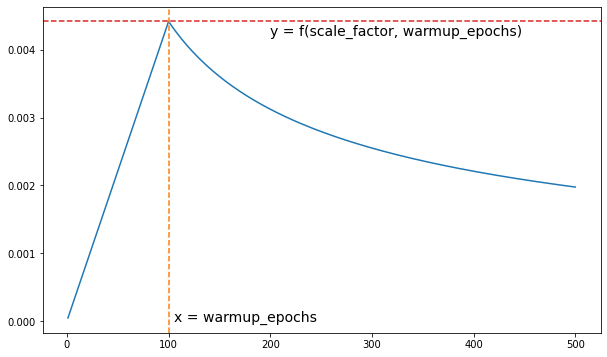

In [89]:
model_dim = 512
scale_factor = 1
warmup_epochs = 100

noam = Noam(model_dim, scale_factor, warmup_epochs)
space = np.linspace(1, 500, num=500)

plt.figure(figsize=(10, 6))
plt.plot(space, noam(space))
plt.axvline(warmup_epochs, linestyle="--", color="C1")
plt.text(warmup_epochs + 5, 0, "x = warmup_epochs", fontsize=14)
plt.axhline(
    scale_factor * model_dim**-0.5 * warmup_epochs**-0.5, linestyle="--", color="C3"
)
plt.text(
    200,
    scale_factor * model_dim**-0.5 * warmup_epochs**-0.5 - 2e-4,
    "y = f(scale_factor, warmup_epochs)",
    fontsize=14,
);

Поэтому я решил факторизовать Noam и обобщить параметр model_dim, специфичный для трансформеров:
    
$$\text{lr} = \cfrac{\text{scale_factor}}{\text{model_size}^{1/2}}\cdot\min\Bigg(\cfrac{\text{warmup_epochs}^{1/2}}{\text{epoch}^{1/2}}, \cfrac{\text{epoch}}{\text{warmup_epochs}}\Bigg)$$

Где $\text{model_size}$ –– количество параметров модели.

In [73]:
class Lambda:
    def __init__(self, model_size, scale_factor, warmup_epochs):
        self.model_size = model_size
        self.scale_factor = scale_factor
        self.warmup_epochs = warmup_epochs

    def __call__(self, epoch):
        return (
            self.scale_factor
            * self.model_size**-0.5
            * np.minimum(
                self.warmup_epochs**0.5 * epoch**-0.5,
                epoch * self.warmup_epochs**-1,
            )
        )

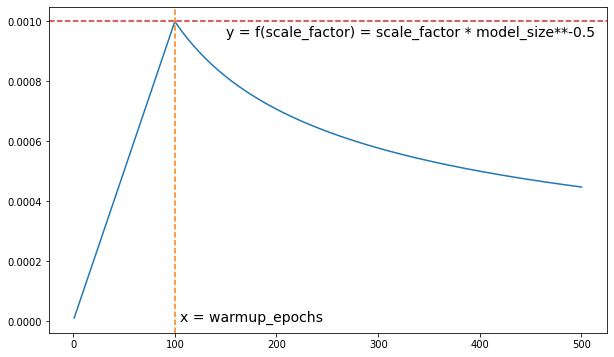

In [88]:
model_size = 1e6
scale_factor = 1
warmup_epochs = 100

lr = Lambda(model_size, scale_factor, warmup_epochs)
space = np.linspace(1, 500, num=500)

plt.figure(figsize=(10, 6))
plt.plot(space, lr(space))
plt.axvline(warmup_epochs, linestyle="--", color="C1")
plt.text(warmup_epochs + 5, 0, "x = warmup_epochs", fontsize=14)
plt.axhline(scale_factor * model_size**-0.5, linestyle="--", color="C3")
plt.text(
    150,
    scale_factor * model_size**-0.5 - 5e-5,
    "y = f(scale_factor) = scale_factor * model_size**-0.5",
    fontsize=14,
);

Теперь $\text{warmup_epochs}$ определяет x координату пика, а $\text{scale_factor}$ –– y координату. Причем при переборе гиперпараметров, в том числе разных lr schedulers, lambda_lr показал себя хорошо с базовым $\text{scale_factor} = 1$, что дает надежду, что перебирать нужно только $\text{warmup_epochs}$. Действительно, домножение на обратный корень размера модели давало пик в 1e-3 при миллионе параметров, что соответствует базовым параметрам многих оптимизаторов, а если обучать BERT c 110 миллионами параметров, получим пик в 1e-4, что соотносится с эвристическими рекомендациями.

![](https://i.imgur.com/zF4mnMr.png)
![](https://i.imgur.com/7iX9Tce.png)

In [5]:
import pickle

import torch

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from Ranking_project.loss import LambdaLoss
from Ranking_project.model import DSSMExtended
from Ranking_project.module import DSSMModule
from Ranking_project.optimizers import OptimizerBuilder

In [7]:
data = pickle.load(
    open(f"Ranking_project/data/max_features_4096_one_hot_-1.pickle", "rb")
)

dssm = DSSMExtended(
    hidden_dimensions=[len(data["vectorizer"].vocabulary_), 256, 128, 64],
    head_dimensions=[
        1 + data["train_dataset"][0]["pairwise_numeric_features"].shape[-1],
        128,
    ],
)

loss_fn = LambdaLoss()

optimizers_config = OptimizerBuilder(
    optimizer_name="adam",
    scheduler_name="lambda",
    min_lr=1e-2,
    max_lr=1e-1,
)

dssm_module = DSSMModule(
    train_dataset=torch.utils.data.ConcatDataset(
        [data["train_dataset"], data["val_dataset"]]
    ),
    val_dataset=data["val_dataset"],
    test_dataset=data["test_dataset"],
    vectorizer=data["vectorizer"],
    dssm=dssm,
    loss_fn=loss_fn,
    optimizers_config=optimizers_config,
    num_workers=4,
)

logger = WandbLogger(project="DSSM")

trainer = Trainer(
    logger=logger,
    max_epochs=50,
    accelerator="gpu",
    gpus=[1],
)

trainer.fit(dssm_module)
trainer.test(ckpt_path="best")
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name    | Type         | Params
-----------------------------------------
0 | dssm    | DSSMExtended | 1.4 M 
1 | loss_fn | LambdaLoss   | 0     
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.764     Total estimated model params size (MB)
/external2/dkkoshman/venv3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /external2/dkkoshman/Notebooks/ML/None/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /external2/dkkoshman/Notebooks/ML/None/version_None/checkpoints/epoch=49-step=88299.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
Loaded model weights from checkpoint at /external2/dkkoshman/Notebooks/ML/None/version_None/checkpoints/epoch=49-step=88299.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_ndcg': 0.7680124339372474}
--------------------------------------------------------------------------------


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_ndcg,▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_ndcg,▁▁▂▅▇▇█▇█▇██████████████████████████████
epoch,50
test_ndcg,0.76801
trainer/global_step,88300
val_ndcg,0.77747


---
Получили качество на тесте 0.768, что немного меньше yeti_rank baseline 0.772

Ну и напоследок поиграем с базовой моделью DSSM:

In [ ]:
from Ranking_project.model import DSSM

data = pickle.load(open(f"Ranking_project/data/max_features_4096.pickle", "rb"))

dssm = DSSM(hidden_dimensions=[len(data["vectorizer"].vocabulary_), 256, 128, 64])

dssm_module = DSSMModule(
    train_dataset=torch.utils.data.ConcatDataset(
        [data["train_dataset"], data["val_dataset"]]
    ),
    val_dataset=data["val_dataset"],
    test_dataset=data["test_dataset"],
    vectorizer=data["vectorizer"],
    dssm=dssm,
    loss_fn=loss_fn,
    optimizers_config=optimizers_config,
    num_workers=4,
)

logger = WandbLogger(project="DSSM")

trainer = Trainer(
    logger=logger,
    max_epochs=20,
    accelerator="gpu",
    gpus=[1],
)

trainer.fit(dssm_module)
trainer.test(ckpt_path="best")
wandb.finish()

In [151]:
query = train.query("query_id == 73").queries_query.iloc[0]
documents = train.query("query_id == 73").orgs_org_name.values
relevance = dssm_module.predict("гостиницы", documents)
df = pd.DataFrame(documents[(-relevance).argsort()])

In [156]:
print(query)

гостиницы


In [157]:
print("Top 10:")
df.head(10)

Top 10:


,0
0,гостиница
1,готель хеллі
2,privat hotel
3,готель набі
4,готель нафтуся
5,готель mirotel resort spa
6,magnet hotel
7,готель вiан
8,готель джем
9,готель олега


In [158]:
print("Bottom 10:")
df.tail(10)

Bottom 10:


,0
155,old town bar
156,вісак
157,таиф нк
158,совет ветеранов нк нпз оо
159,real
160,утёс
161,вілла калина
162,аэропорт новый уренгой
163,мидем
164,taraça bar restoran
